In [32]:
#The usual collection of indispensables 
import numpy as np
import matplotlib.pyplot as plt
import datetime
import scipy.fftpack

# And the tf and keras framework, thanks to Google
import tensorflow as tf
from tensorflow import keras

In [33]:
# Time series prediction model
def dnn_keras_tspred_model():
    model = keras.Sequential([
        keras.layers.Dense(32, activation=tf.nn.relu,input_shape=(train_data.shape[1],)),
        keras.layers.Dense(8, activation=tf.nn.relu),
        keras.layers.Dense(1)])
    optimizer = tf.keras.optimizers.Adam()
    model.compile(loss='mse',optimizer=optimizer,metrics=['mae']) 
    model.summary()
    return model

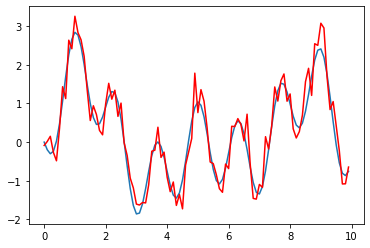

In [34]:
num_train_data = 4000
num_test_data = 1000
timestep = 0.1
tm =  np.arange(0, (num_train_data+num_test_data)*timestep, timestep);
y = np.sin(tm) + np.sin(tm*np.pi/2) + np.sin(tm*(-3*np.pi/2)) 
SNR = 10
ypn = y + np.random.normal(0,10**(-SNR/20),len(y))

plt.plot(tm[0:100],y[0:100])
plt.plot(tm[0:100],ypn[0:100],'r') # red one is the noisy signal
plt.show()

In [67]:
print(len(ypn))

5000


In [73]:
# prepare the train_data and train_labels
dnn_numinputs = 64
num_train_batch = 0
train_data = []
for k in range(num_train_data-dnn_numinputs-1):
    train_data = np.concatenate((train_data,ypn[k:k+dnn_numinputs]));
    num_train_batch = num_train_batch + 1  
    
    
train_data = np.reshape(train_data, (num_train_batch,dnn_numinputs)) #num_train_batch <---- number of rows dnn_numinputs <---number of columns
train_labels = y[dnn_numinputs:num_train_batch+dnn_numinputs]

In [20]:
print(y.shape, train_data.shape, train_labels.shape)


(5000,) (3935, 64) (3935,)


In [21]:
model = dnn_keras_tspred_model()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 2,353
Trainable params: 2,353
Non-trainable params: 0
_________________________________________________________________


DNN training done. Time elapsed:  10.132066 s


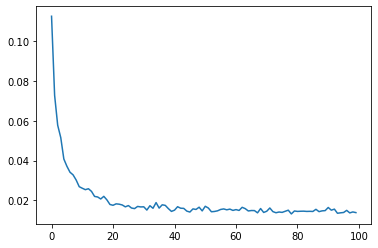

In [22]:
EPOCHS = 100
strt_time = datetime.datetime.now()
history = model.fit(train_data, train_labels, epochs=EPOCHS,
                  validation_split=0.2, verbose=0,
                  callbacks=[])

curr_time = datetime.datetime.now()
timedelta = curr_time - strt_time
dnn_train_time = timedelta.total_seconds()
print("DNN training done. Time elapsed: ", timedelta.total_seconds(), "s")
plt.plot(history.epoch, np.array(history.history['val_loss']),
           label = 'Val loss')
plt.show()

In [23]:
# test how well DNN predicts now
num_test_batch = 0
strt_idx = num_train_batch
test_data=[]
for k in range(strt_idx, strt_idx+num_test_data-dnn_numinputs-1):
    test_data = np.concatenate((test_data,ypn[k:k+dnn_numinputs]));
    num_test_batch = num_test_batch + 1  
test_data = np.reshape(test_data, (num_test_batch, dnn_numinputs))
test_labels = y[strt_idx+dnn_numinputs:strt_idx+num_test_batch+dnn_numinputs]

In [ ]:
# prepare the train_data and train_labels
dnn_numinputs = 64
num_train_batch = 0
train_data = []
for k in range(num_train_data-dnn_numinputs-1):
    train_data = np.concatenate((train_data,ypn[k:k+dnn_numinputs]));
    num_train_batch = num_train_batch + 1  
    
    
train_data = np.reshape(train_data, (num_train_batch,dnn_numinputs)) #num_train_batch <---- number of rows dnn_numinputs <---number of columns
train_labels = y[dnn_numinputs:num_train_batch+dnn_numinputs]

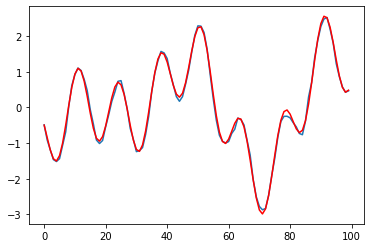

In [24]:
dnn_predictions = model.predict(test_data).flatten()
keras_dnn_err = test_labels - dnn_predictions
plt.plot(dnn_predictions[0:100])
plt.plot(test_labels[0:100],'r')
plt.show()

(64,) (1064,)


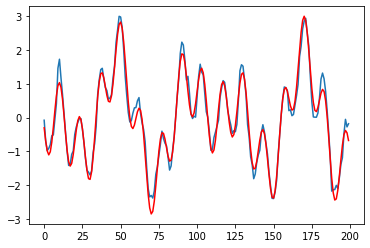

In [25]:
#LMS
M = 1000
L = 64
yrlms = np.zeros(M+L)
#wn = np.random.normal(0,1,L)
wn = np.zeros(L)
print(wn.shape, yrlms.shape)
mu = 0.005
for k in range(L,M+L):
    yrlms[k] = np.dot(ypn[k-L:k],wn)
    e = ypn[k]- yrlms[k]
    wn=wn+(mu*ypn[k-L:k]*e)

plt.plot(yrlms[600:800])
plt.plot(y[600:800],'r')
plt.show()

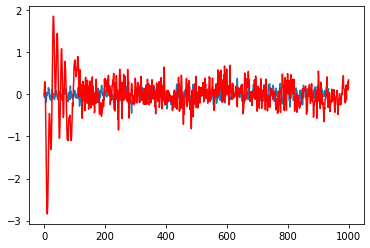

Neural network SNR: 20.978189998571747
LMS Prediction SNR: 14.476219714848778


In [26]:
dnn_err = dnn_predictions - test_labels
lms_err = yrlms[0:M] - y[0:M]
plt.plot(dnn_err)
plt.plot(lms_err,'r')
plt.show()

dnn_mse = 10*np.log10(np.mean(pow(np.abs(dnn_err),2)))
lms_mse = 10*np.log10(np.mean(pow(np.abs(lms_err[200:M]),2)))
lms_sigpow = 10*np.log10(np.mean(pow(np.abs(y[0:M]),2)))
dnn_sigpow = 10*np.log10(np.mean(pow(np.abs(test_labels),2)))

#print(dnn_mse, dnn_sigpow, lms_mse, lms_sigpow)
print("Neural network SNR:", dnn_sigpow - dnn_mse)
print("LMS Prediction SNR:", lms_sigpow - lms_mse)

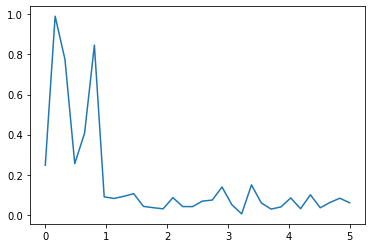

In [27]:
# 64 point FFT
N = 64

# Using the same noisy signal used for LMS
yf = scipy.fftpack.fft(ypn[0:N])

# Let us remove noise, easy to do at the FFT output
#yc = np.zeros(N,dtype=complex)
#cidx = np.where(np.abs(yf)>(N*0.2/2))[0]
#yc[cidx]=yf[cidx]

# 0 to Fs/2, Fs = 1/Ts
xf = np.linspace(0.0, 1.0/(2*timestep), int(N/2))

#fig, ax = plt.subplots()
# Plotting only from 0 to Fs/2
#plt.plot(xf, 2.0/N * np.abs(yc[:N//2]),'r')
plt.plot(xf, 2.0/N * np.abs(yf[:N//2]))
plt.show()

In [28]:
def dnn_keras_fft_model():
    model = keras.Sequential([
    keras.layers.Dense(NFFT*2, activation=tf.nn.relu,
                       input_shape=(train_data.shape[1],)),
    keras.layers.Dense(NFFT*2, activation=tf.nn.relu),
    keras.layers.Dense(NFFT*2)
    ])
    optimizer = tf.keras.optimizers.Adam()
    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae']) 
    model.summary()
    return model

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
Total params: 49,536
Trainable params: 49,536
Non-trainable params: 0
_________________________________________________________________
DNN training done. Time elapsed:  19.64325 s


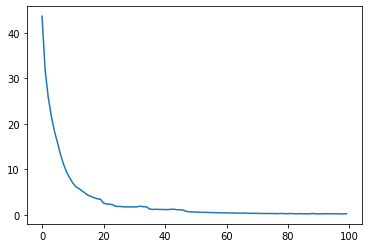

In [29]:
# Train the DNN for 16 point FFT
NFFT = 64
num_train_batch = 1
num_batches = 10000
train_data = np.random.normal(0,1,(num_batches, NFFT*2))
train_labels = np.random.normal(0,1,(num_batches, NFFT*2))
model = dnn_keras_fft_model()
for k in range(num_train_batch):
    for el in range(num_batches):
        fftin = train_data[el,0::2] + 1j*train_data[el,1::2]
        train_labels[el,0::2]=scipy.fftpack.fft(fftin).real
        train_labels[el,1::2]=scipy.fftpack.fft(fftin).imag
    EPOCHS = 100
    strt_time = datetime.datetime.now()
    history = model.fit(train_data, train_labels, epochs=EPOCHS,
                    validation_split=0.2, verbose=0,
                    callbacks=[])
    curr_time = datetime.datetime.now()
    timedelta = curr_time - strt_time
    dnn_train_time = timedelta.total_seconds()
    print("DNN training done. Time elapsed: ", timedelta.total_seconds(), "s")
    plt.plot(history.epoch, np.array(history.history['val_loss']),
            label = 'Val loss')
    plt.show()
    train_data = np.random.normal(0,1,(num_batches, NFFT*2))

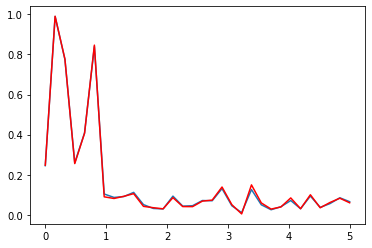

In [30]:
fftin = np.zeros((1,2*NFFT))
fftin[:,0::2]=ypn[0:NFFT]
fftout = model.predict(fftin).flatten()
fftout = fftout[0::2] + 1j*fftout[1::2]
plt.plot(xf, 2.0/NFFT * np.abs(fftout[0:NFFT//2]))
plt.plot(xf, 2.0/N * np.abs(yf[:N//2]),'r')
plt.show()

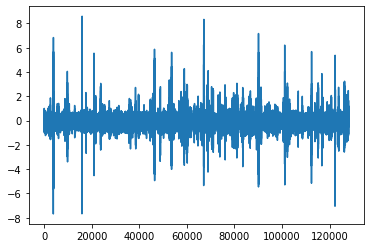

Neural Network SNR compare to SciPy FFT:  25.445834754565546


In [31]:
test_data = np.random.normal(0,1,(1000, NFFT*2))
test_labels = np.random.normal(0,1,(1000, NFFT*2))
for el in range(1000):
    fftin = test_data[el,0::2] + 1j*test_data[el,1::2]
    test_labels[el,0::2]=scipy.fftpack.fft(fftin).real
    test_labels[el,1::2]=scipy.fftpack.fft(fftin).imag

dnn_out = model.predict(test_data).flatten()
keras_dnn_err = test_labels.flatten() - dnn_out
plt.plot(keras_dnn_err)
plt.show()

dnn_fft_mse = 10*np.log10(np.mean(pow(np.abs(keras_dnn_err),2)))
labels_sigpow = 10*np.log10(np.mean(pow(np.abs(test_labels.flatten()),2)))
print("Neural Network SNR compare to SciPy FFT: ", labels_sigpow - dnn_fft_mse)